In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# parameters
eps11 = -7 #MHz 
dt  = 1
tau_B = 1e9
tau_eps = 1e2
sig_eps = 10
sig_B = 30
n = 1000
sig_measure = 0.1

def J(eps, J0 = 20, J1 = 725, eps0 = 4.4):
    return J0 + J1*np.exp(eps/eps0)


def eps_J(J, J0 = 20, J1 = 725, eps0 = 4.4):
    return (np.log((J - J0)/J1))*eps0

# single step of o-u process with time step dt, and correlation time tau, and variance sigma
def ou_step(x, dt, tau, sigma):
    return x - dt/tau * x + np.sqrt(dt) * sigma * np.random.randn()

# simulate the o-u process with time step dt, and correlation time tau, and variance sigma
def ou_process(dt, tau, sigma, n):
    x = np.zeros(n)
    x[0]  = np.random.randn()
    for i in range(1, n):
        x[i] = ou_step(x[i-1], dt, tau, sigma)
    return x

# simulate the measurement of the frequency with noise
def measure(B, eps):
    om_ideal = np.sqrt(B**2 + J(eps)**2)
    noise = sig_measure*np.random.randn()
    return om_ideal + noise


# simulate the measurement of the frequencies at two detunigs with noise
def single_run(N, B, deps):
    om11 = np.zeros(N)     
    om02 = np.zeros(N)
    dom11 = np.zeros(N)
    dom02 = np.zeros(N)
    for n in range(N):

        #measurm ent at (1,1)
        B = ou_step(B, dt, tau_B, sig_B)
        deps = ou_step(deps, dt, tau_eps, sig_eps)
        om11[n] = measure(B, eps11+deps)
        dom11[n] = om11[n] - np.sqrt(B**2 + J(eps11)**2)

        #inference of B
        eps02 = eps_J(om11[-1]**2 - B**2)

        #alternatively
        #eps02 = eps02_fixed

        #measurment at (0,2)
        B = ou_step(B, dt, tau_B, sig_B)
        deps = ou_step(deps, dt, tau_eps, sig_eps)
        om02[n] =  measure(B, eps02+deps)
        dom02[n] = om02[n] - np.sqrt(B**2 + J(eps02)**2)
        #feedback of eps   

    









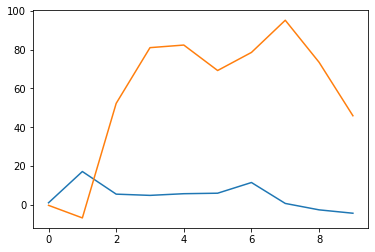

In [8]:
single_run(10, 0, 0)